# Customer Churn Predictions 
(End-to-end customer churn prediction project) 
### Using Telco Customer Churn dataset 

In [1]:
# Check to make sure dpendencies are installed

In [3]:
# Importing libraries 
import os 
import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path 


In [4]:
# Setting random_state for reproducibility 
random_state = 42 
np.random.seed(random_state) 


In [17]:
# Defining folder paths 
# Current directory --> Notebooks/ 
#data_path = "../Data/telco_churn_data.csv" 
#visuals_path = "../Visuals"
#model_path = "../Models"   

data_path = Path('../Data/telco_churn_data.csv').resolve() 
base_data_path = Path('../Data').resolve() 
visuals_path = Path('../Visuals').resolve()  
models_path = Path('../Models').resolve() 

visuals_path.mkdir(parents=True, exist_ok=True) 
models_path.mkdir(parents=True, exist_ok=True) 

print("Data Path --> ", data_path) 
print("Base Data Path -- ", base_data_path) 
print("Visuals Path --> ", visuals_path) 
print("Models Path --> ", models_path) 

# Function to save data file(s) to Data/ folder 
def save_data(data: pd.DataFrame, file_name: str): 
    os.makedirs(base_data_path, exist_ok=True) 
    file_path = os.path.join(base_data_path, f"{file_name}.csv") 
    data.to_csv(file_path, index=False) 
    print(f"Saved -> {file_path}") 


Data Path -->  /workspaces/Customer-Churn-Prediction/Data/telco_churn_data.csv
Base Data Path --  /workspaces/Customer-Churn-Prediction/Data
Visuals Path -->  /workspaces/Customer-Churn-Prediction/Visuals
Models Path -->  /workspaces/Customer-Churn-Prediction/Models


In [18]:
# Plotting settings 
sns.set_style('whitegrid') 
plt.rcParams['figure.figsize'] = (10,6) 


In [19]:
# Loading data 

# file path check 
if not data_path.exists(): 
    raise FileNotFoundError(f"Expected data at {data_path}.") 

telco_data = pd.read_csv(data_path) 
telco_data.head() 
print("\nData Info: ")
print(telco_data.info())  




Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nu

In [20]:
data = telco_data.copy() 

# Data checks 
print("\nMissing values: ") 
print(data.isna().sum()) 

# Checking if there are duplicate customerID values 
print("\nAll unique customerID --> ", data['customerID'].nunique() == len(data)) 

# Converting TotalCharges to numeric 
if data['TotalCharges'].dtype == 'object': 
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') 
    print("\nTotalCharges NA count (After numeric conversion): ", data['TotalCharges'].isna().sum())

# Checking if any rows have tenure == 0 & TotalCharges == NaN 
# Possible for new customers 
new_cust = (data['tenure'] == 0) & (data['TotalCharges'].isna()) 
print("\nRows with tenure == 0 & TotalCharges == NaN : ", new_cust.sum()) 




Missing values: 
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

All unique customerID -->  True

TotalCharges NA count (After numeric conversion):  11

Rows with tenure == 0 & TotalCharges == NaN :  11


In [21]:
# Changing TotalCharges to 0 if tenure==0 (Assumed it is a new customer) 
# If any TotalCharges==NaN remain these will be handled later 
data.loc[(data['tenure']==0) & (data['TotalCharges'].isna()), 'TotalCharges'] = 0.0 
print("Remaining NaN TotalCharges values after fix: ", data['TotalCharges'].isna().sum()) 


Remaining NaN TotalCharges values after fix:  0


In [27]:
# Encoding the SeniorCitizen column to match the other columns (converting 0/1 to labels) 
data['SeniorCitizen'] = data['SeniorCitizen'].map({0:'No', 1:'Yes'}) 
print(data['SeniorCitizen'].head())


0    No
1    No
2    No
3    No
4    No
Name: SeniorCitizen, dtype: object


In [28]:
# Saving cleaned data to Data/ folder 
save_data(data, "cleaned_raw_data") 


Saved -> /workspaces/Customer-Churn-Prediction/Data/cleaned_raw_data.csv


### Exploratory Data Analysis (EDA) 
Looking at group churn rates, population comparisons, visualziations, and interpretations. 

In [29]:
# Finding baseline churn rate (Total churn rate) 
print("Baseline churn:") 
print(data['Churn'].value_counts(normalize=True)) 


Baseline churn:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


**Baseline Churn Rate: 26.54%**

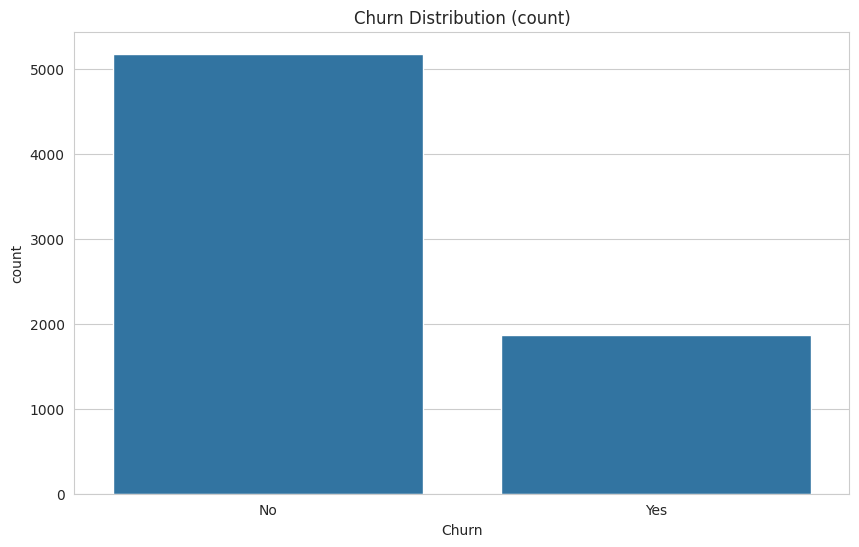

In [30]:
# Churn distribution 
ax = sns.countplot(x='Churn', data=data) 
ax.set_title("Churn Distribution (count)") 
plt.savefig(visuals_path / 'churn_distribution.png', dpi=150, bbox_inches='tight') 
plt.show() 


In [26]:
test_crosstab = pd.crosstab(data['Partner'], data['Churn'], normalize='index') 
test_crosstab = test_crosstab.rename(columns={'No': 'churn_no_pct', 'Yes': 'churn_yes_pct'}) 
test_crosstab

Churn,churn_no_pct,churn_yes_pct
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


In [31]:
# Creating helper function to calculate cross-tabulations and group churn rates 
def group_churn(data, group_column, target='Churn'): 
    # In-group churn 
    cross_tab = pd.crosstab(data[group_column], data[target], normalize='index') 
    cross_tab = cross_tab.rename(columns={'No': 'churn_no_pct', 'Yes': 'churn_yes_pct'}) 
    # Population comparison 
    population_share = data[group_column].value_counts(normalize=True).rename('population_share') 
    result = cross_tab.join(population_share) 
    result['group_churn'] = result['churn_yes_pct'] 
    result['population_churn_share'] = result['population_share'] * result['churn_yes_pct'] 
    return result 



In [34]:
# Calculating cross-tabs for SneiorCitizen 
# Adding calculations to separate Senior/Non-Senior 
senior_crosstab = pd.crosstab(data['SeniorCitizen'], data['Churn'], normalize=True, margins=True) 
senior_crosstab = senior_crosstab.rename(columns={'No':'churn_no_pct', 'Yes':'churn_yes_pct'})
print("Senior Citizen cross-tabulation: ") 
senior_crosstab


Senior Citizen cross-tabulation: 


Churn,churn_no_pct,churn_yes_pct,All
SeniorCitizen,,,
No,0.640068,0.197785,0.837853
Yes,0.094562,0.067585,0.162147
All,0.734630,0.265370,1.000000


In [33]:
# Calculating spearate percentages for senior/non-senior 
senior_churn = senior_crosstab.loc['Yes','churn_yes_pct'] if 'Yes' in senior_crosstab.index else None 
non_senior_churn = senior_crosstab.loc['No','churn_yes_pct'] 
print("Senior (in-group) Churn (Yes): ", senior_churn) 
print("\nNon-Senior (in-group) Churn (Yes): ", non_senior_churn) 



Senior (in-group) Churn (Yes):  0.4168126094570928

Non-Senior (in-group) Churn (Yes):  0.23606168446026096


**Note:** <br>
Senior citizens had a population churn rate of 6.76%, however, looking at in-group rates senior citizens had a much higher churn rate of 41.68% compared to non-senior citizens in-group churn rate of 23.61%.  
Despite senior citizens having the higher in-group churn rate, non-senior citizens still had a much higher population churn share (19.78%). 

                group_churn  population_share  population_churn_share
Contract                                                             
Month-to-month     0.427097          0.550192                0.234985
One year           0.112695          0.209144                0.023570
Two year           0.028319          0.240664                0.006815


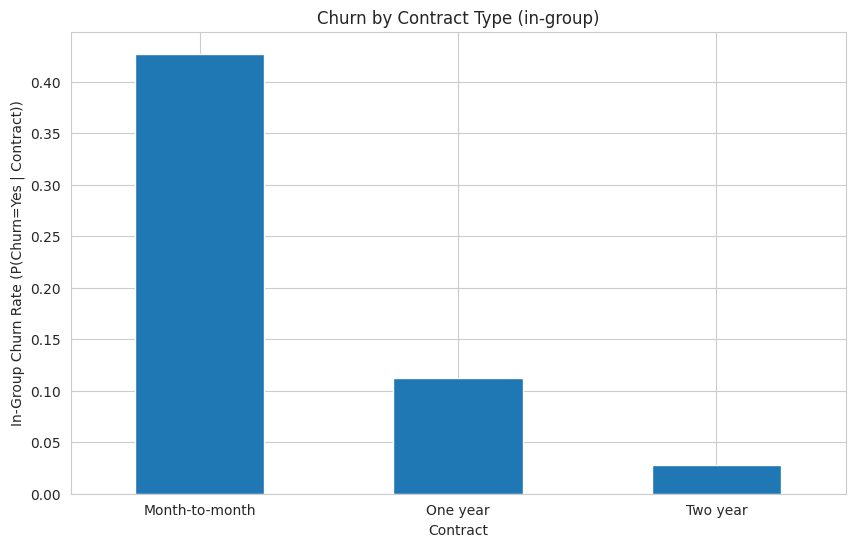

In [36]:
# Contract type and churn 
contract_stats = group_churn(data, 'Contract') 
print(contract_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = contract_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate (P(Churn=Yes | Contract))') 
ax.set_title('Churn by Contract Type (in-group)') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_contract.png', dpi=150, bbox_inches='tight') 
plt.show() 


                 group_churn  population_share  population_churn_share
InternetService                                                       
DSL                 0.189591          0.343746                0.065171
Fiber optic         0.418928          0.439585                0.184154
No                  0.074050          0.216669                0.016044


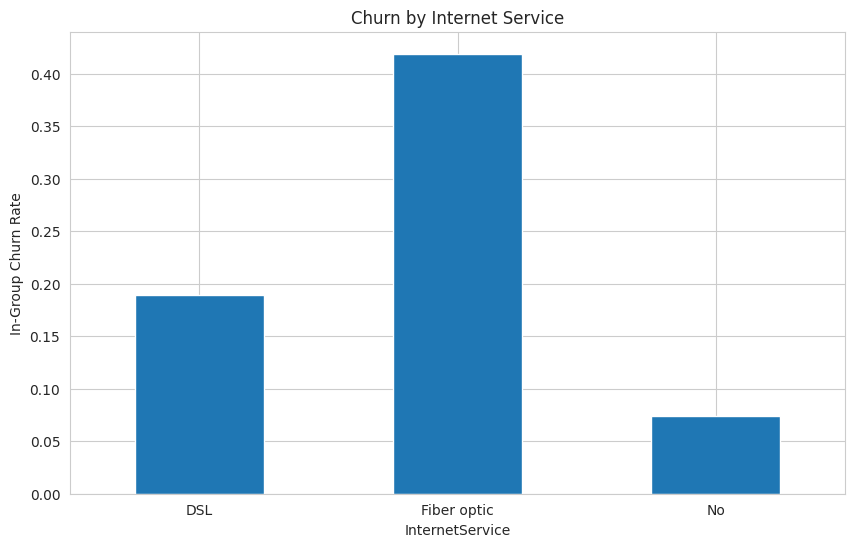

In [37]:
# Internet service and churn 
InternetService_stats = group_churn(data, 'InternetService') 
print(InternetService_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = InternetService_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Internet Service') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_internet_service.png', dpi=150, bbox_inches='tight') 
plt.show() 


        group_churn  population_share  population_churn_share
gender                                                       
Female     0.269209          0.495244                0.133324
Male       0.261603          0.504756                0.132046


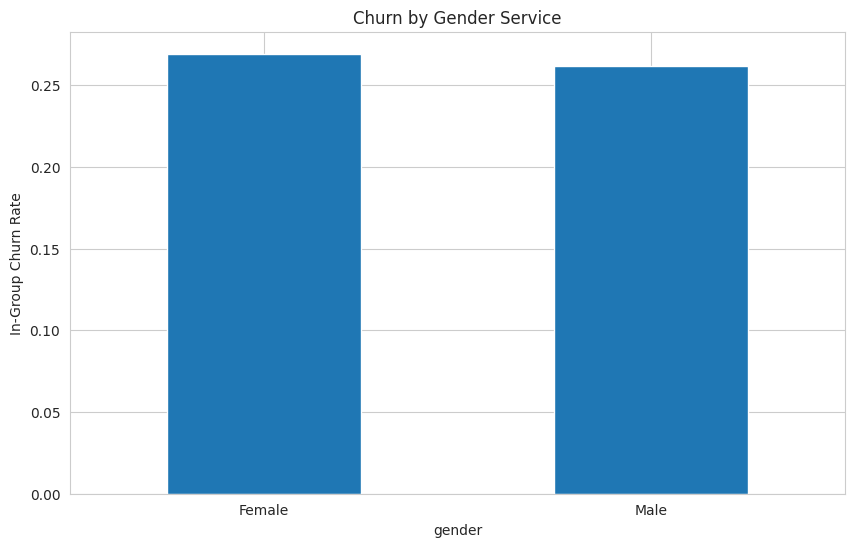

In [38]:
# Gender and churn 
gender_stats = group_churn(data, 'gender') 
print(gender_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = gender_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Gender Service') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_gender.png', dpi=150, bbox_inches='tight') 
plt.show() 


         group_churn  population_share  population_churn_share
Partner                                                       
No          0.329580          0.516967                0.170382
Yes         0.196649          0.483033                0.094988


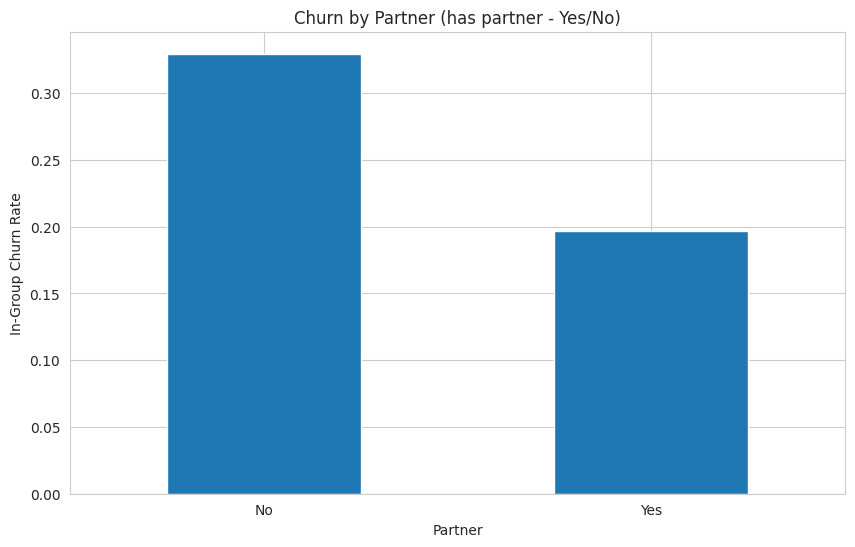

In [41]:
# Partner and churn 
partner_stats = group_churn(data, 'Partner') 
print(partner_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = partner_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Partner (has partner - Yes/No)') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_partner.png', dpi=150, bbox_inches='tight') 
plt.show() 


            group_churn  population_share  population_churn_share
Dependents                                                       
No             0.312791          0.700412                0.219083
Yes            0.154502          0.299588                0.046287


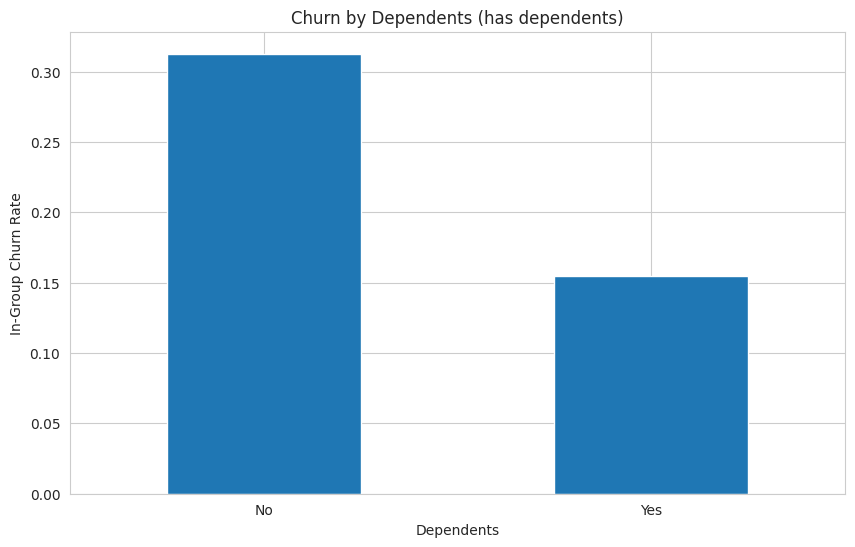

In [42]:
# Dependents and churn 
dependents_stats = group_churn(data, 'Dependents') 
print(dependents_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = dependents_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Dependents (has dependents)') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_dependents.png', dpi=150, bbox_inches='tight') 
plt.show()


              group_churn  population_share  population_churn_share
PhoneService                                                       
No               0.249267          0.096834                0.024137
Yes              0.267096          0.903166                0.241232


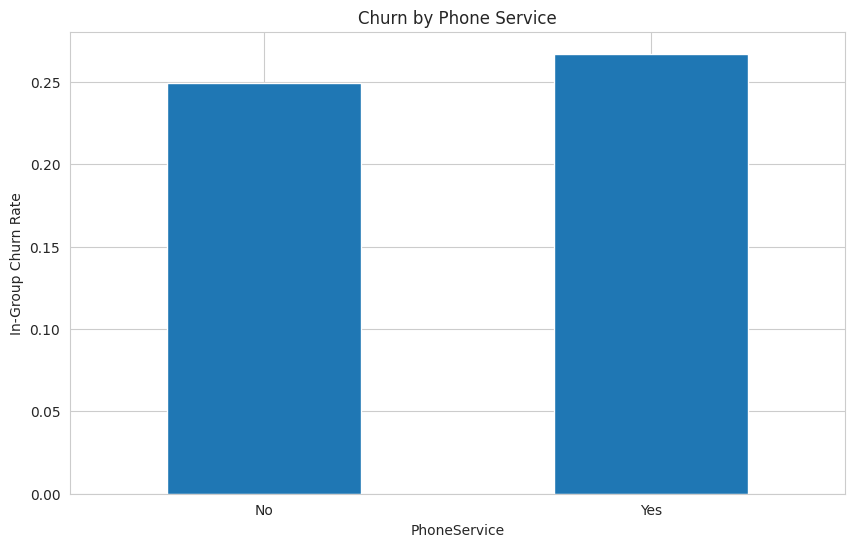

In [43]:
# Phone service and churn 
PhoneService_stats = group_churn(data, 'PhoneService') 
print(PhoneService_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PhoneService_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Phone Service') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_phone_service.png', dpi=150, bbox_inches='tight') 
plt.show()


                  group_churn  population_share  population_churn_share
MultipleLines                                                          
No                   0.250442          0.481329                0.120545
No phone service     0.249267          0.096834                0.024137
Yes                  0.286099          0.421837                0.120687


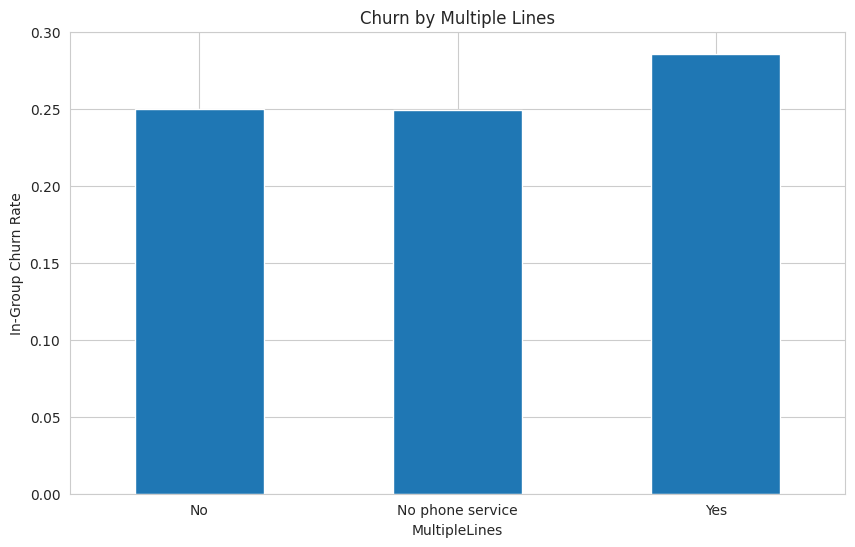

In [44]:
# Multiple lines and churn 
MultipleLines_stats = group_churn(data, 'MultipleLines') 
print(MultipleLines_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = MultipleLines_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Multiple Lines') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_multiple_lines.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
OnlineSecurity                                                            
No                      0.417667          0.496663                0.207440
No internet service     0.074050          0.216669                0.016044
Yes                     0.146112          0.286668                0.041886


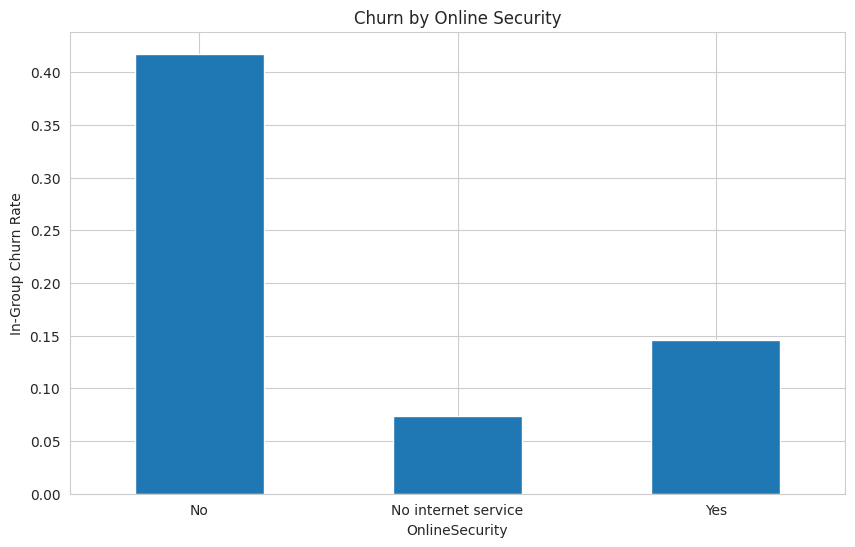

In [45]:
# Online security and churn 
OnlineSecurity_stats = group_churn(data, 'OnlineSecurity') 
print(OnlineSecurity_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = OnlineSecurity_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Online Security') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_online_security.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
OnlineBackup                                                              
No                      0.399288          0.438450                0.175067
No internet service     0.074050          0.216669                0.016044
Yes                     0.215315          0.344881                0.074258


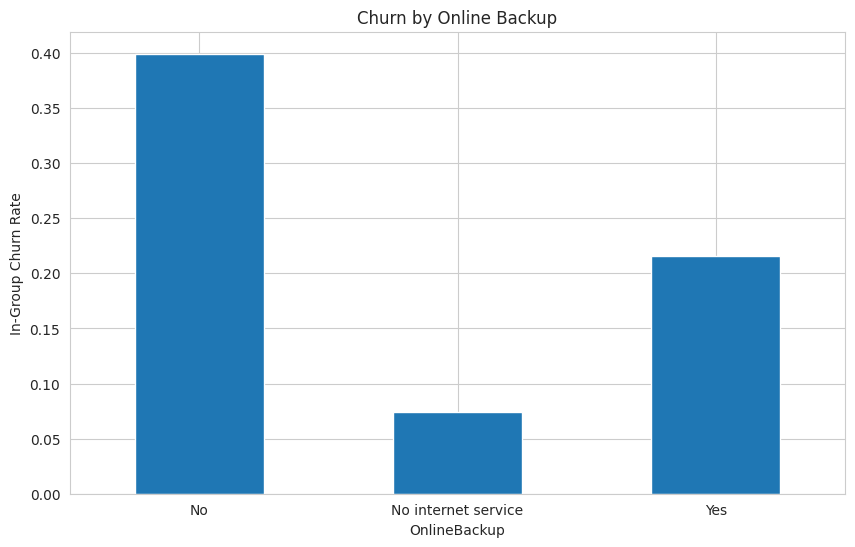

In [46]:
# Online backup and churn 
OnlineBackup_stats = group_churn(data, 'OnlineBackup') 
print(OnlineBackup_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = OnlineBackup_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Online Backup') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_online_backup.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
DeviceProtection                                                          
No                      0.391276          0.439443                0.171944
No internet service     0.074050          0.216669                0.016044
Yes                     0.225021          0.343888                0.077382


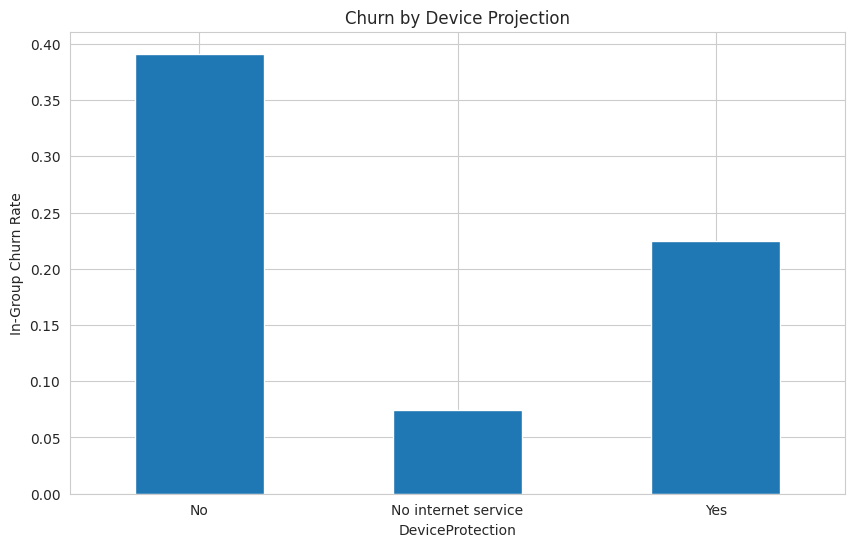

In [47]:
# Device protection and churn 
DeviceProtection_stats = group_churn(data, 'DeviceProtection') 
print(DeviceProtection_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = DeviceProtection_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Device Projection') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_device_protection.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
TechSupport                                                               
No                      0.416355          0.493114                0.205310
No internet service     0.074050          0.216669                0.016044
Yes                     0.151663          0.290217                0.044015


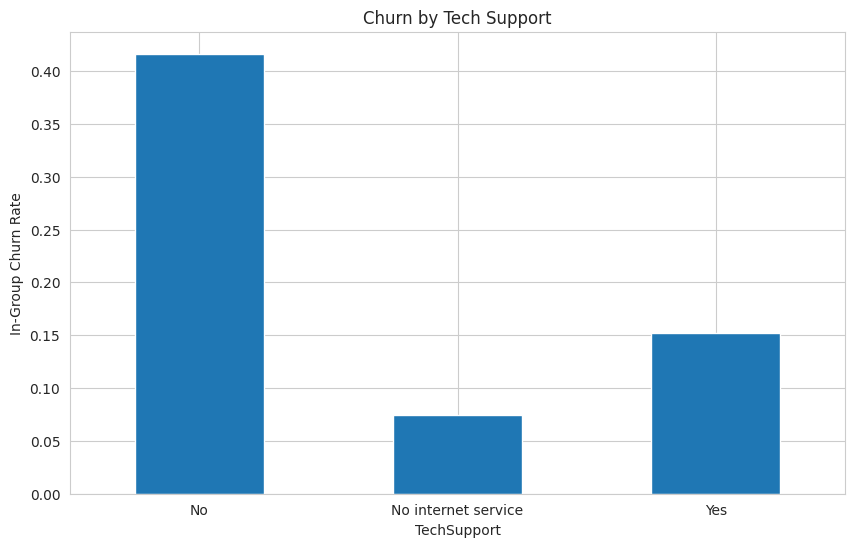

In [48]:
# Tech support and churn 
TechSupport_stats = group_churn(data, 'TechSupport') 
print(TechSupport_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = TechSupport_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Tech Support') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_tech_support.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
StreamingTV                                                               
No                      0.335231          0.398978                0.133750
No internet service     0.074050          0.216669                0.016044
Yes                     0.300702          0.384353                0.115576


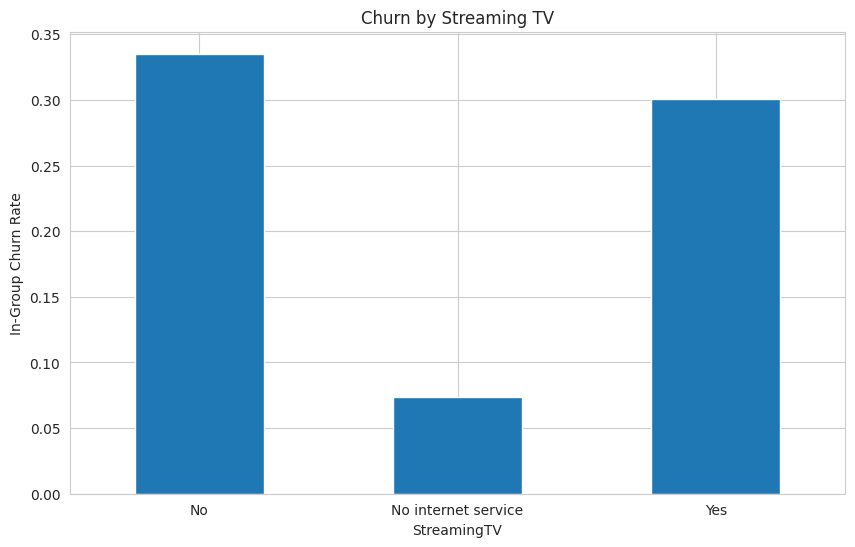

In [49]:
# Streaming TV and churn 
StreamingTV_stats = group_churn(data, 'StreamingTV') 
print(StreamingTV_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = StreamingTV_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Streaming TV') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_streaming_tv.png', dpi=150, bbox_inches='tight') 
plt.show()


                     group_churn  population_share  population_churn_share
StreamingMovies                                                           
No                      0.336804          0.395428                0.133182
No internet service     0.074050          0.216669                0.016044
Yes                     0.299414          0.387903                0.116144


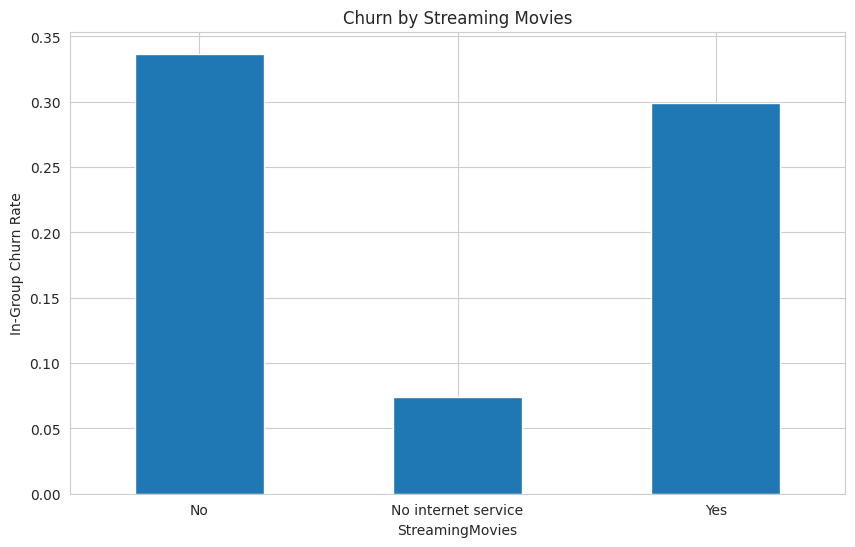

In [50]:
# Streaming movies and churn 
StreamingMovies_stats = group_churn(data, 'StreamingMovies') 
print(StreamingMovies_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = StreamingMovies_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Streaming Movies') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_streaming_movies.png', dpi=150, bbox_inches='tight') 
plt.show()


                  group_churn  population_share  population_churn_share
PaperlessBilling                                                       
No                   0.163301          0.407781                0.066591
Yes                  0.335651          0.592219                0.198779


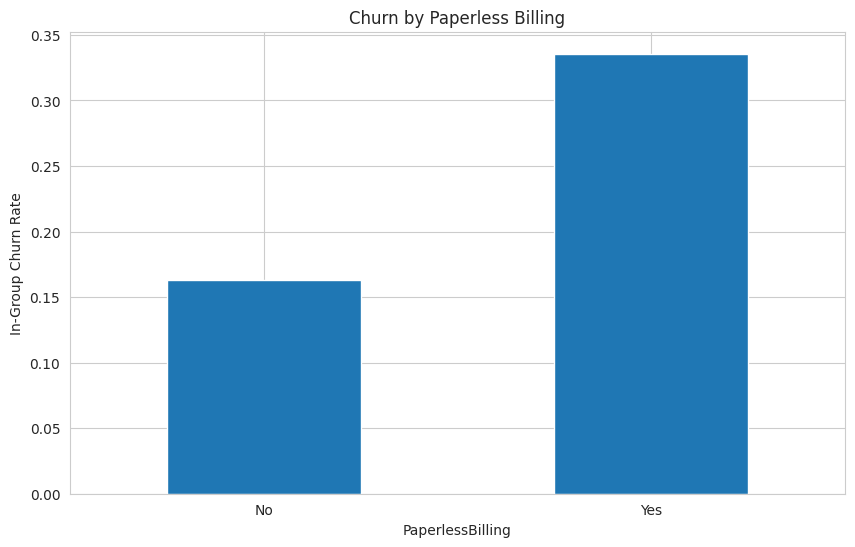

In [51]:
# Paperless billing and churn 
PaperlessBilling_stats = group_churn(data, 'PaperlessBilling') 
print(PaperlessBilling_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PaperlessBilling_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Paperless Billing') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_paperless_billing.png', dpi=150, bbox_inches='tight') 
plt.show()


                           group_churn  ...  population_churn_share
PaymentMethod                           ...                        
Bank transfer (automatic)     0.167098  ...                0.036632
Credit card (automatic)       0.152431  ...                0.032941
Electronic check              0.452854  ...                0.152066
Mailed check                  0.191067  ...                0.043731

[4 rows x 3 columns]


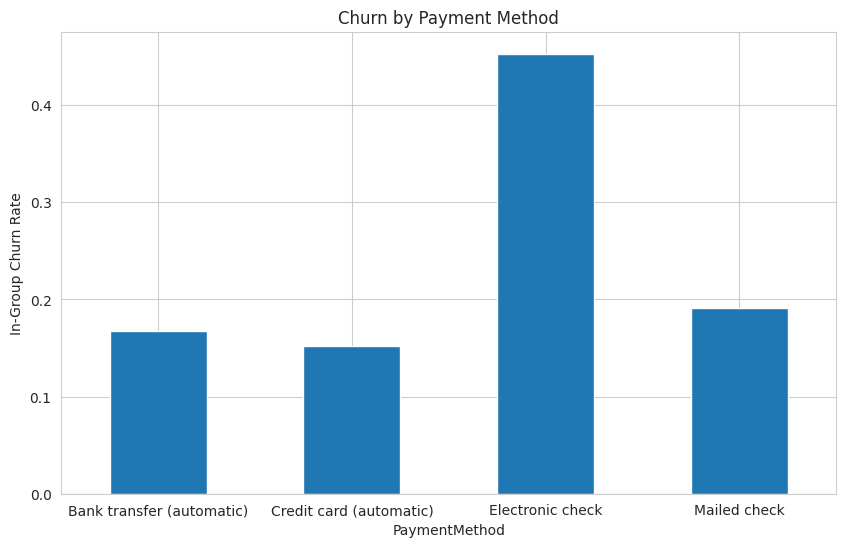

In [52]:
# Payment method and churn 
PaymentMethod_stats = group_churn(data, 'PaymentMethod') 
print(PaymentMethod_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PaymentMethod_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Payment Method') 
plt.xticks(rotation=0) 
# Saving figure 
plt.savefig(visuals_path / 'churn_by_payment_method.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Machine Learning Libraries 
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV  
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    roc_curve, 
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline 

import joblib 

# Heavy Libraries 
try: 
    import xgboost as xgb 
except Exception: 
    xgb = None 

try: 
    import shap 
except Exception: 
    shap = None 
